In [334]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
import cvxpy as cp
import random
random.seed(1)

# Fire Risk Model

In [233]:
def fire_avg_interarrival(dist):
    return 18*np.log(dist)

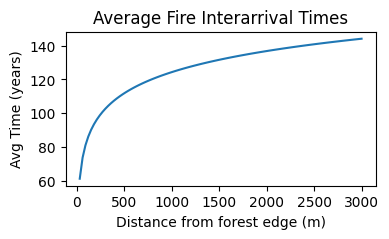

In [237]:
x = np.linspace(30, 3000, 100)
plt.figure(figsize=(4, 2))
plt.plot(x, fire_avg_interarrival(x))

plt.ylabel('Avg Time (years)')
plt.xlabel('Distance from forest edge (m)')
plt.title('Average Fire Interarrival Times')
plt.show()

/var/folders/l_/zjyw1l0d37x3lbbq6x4vvs_00000gn/T/ipykernel_5507/2647702212.py:2: RuntimeWarning: divide by zero encountered in log
  return 18*np.log(dist)
/var/folders/l_/zjyw1l0d37x3lbbq6x4vvs_00000gn/T/ipykernel_5507/3311575101.py:10: RuntimeWarning: divide by zero encountered in log
  plt.contourf(np.log(annual_fire_risk), cmap="Reds", levels=100)


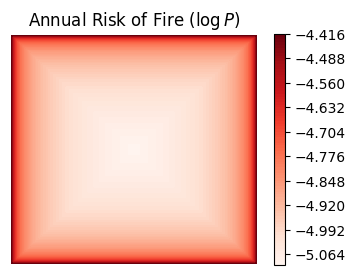

In [277]:
N = 173
d1 = np.vstack([np.arange(0, N) for _ in range(n)])
dist = d1.copy()
for i in range(1, 4):
    dist = np.minimum(dist, np.rot90(d1, i))

annual_fire_risk = 1/fire_avg_interarrival(dist * 100)

plt.figure(figsize=(4, 3))
plt.contourf(np.log(annual_fire_risk), cmap="Reds", levels=100)
plt.axis("off")
plt.title("Annual Risk of Fire ($\log P$)")
plt.colorbar()
plt.show()

# Allocations

In [ ]:
EFFECTIVE_INTEREST_RATE = 0.05

In [201]:
# price per cubic meter
M_price = 1300
E_price = 25

# m^3 harvested per hectare
M_100_harvest = 500
M_200_harvest = 800
E_25_harvest = 500

# shape of a plantation
M_tile = (0.5, 2)
E_tile = (2, 2.5)

In [220]:
M_100_Annual_yield = M_100_harvest / 100
M_200_Annual_yield = M_200_harvest / 200
E_25_Annual_yield = E_25_harvest / 25

discount_factor = 1/(1 + EFFECTIVE_INTEREST_RATE)

M_100_Annual_Revenue = discount_factor**100 * M_100_harvest * M_price
M_200_Annual_Revenue = discount_factor**200 * M_200_harvest * M_price
E_25_Annual_Revenue = discount_factor**25 * E_25_harvest * E_price

print("strategy | $/hectare |  discount | avg annual appreciation")
print("----------------------------------------------------------")
print("M_100    |  ", M_100_harvest * M_price, " | ", round(100*discount_factor**100, 2), "%   |", M_100_Annual_Revenue)
print("M_200    | ", M_200_harvest * M_price, " | ", round(100*discount_factor**200, 2), "%   |", M_200_Annual_Revenue)
print("E_25     |   ", E_25_harvest * E_price, " | ", round(100*discount_factor**25, 2), "%  |", E_25_Annual_Revenue)



strategy | $/hectare |  discount | avg annual appreciation
----------------------------------------------------------
M_100    |   650000  |  0.76 %   | 4942.918498617754
M_200    |  1040000  |  0.01 %   | 60.141398852867916
E_25     |    12500  |  29.53 %  | 3691.2846462220223


In [224]:
m100 = cp.Variable(integer=True)
m200 = cp.Variable(integer=True)
e25 = cp.Variable(integer=True)
r = cp.Variable(integer=True)

parrots_m200 = (0.25*m200)/120
parrots_r = r/120
total_parrots = parrots_m200 + parrots_r

total_annual_yield = m100*M_100_Annual_yield + m200*M_200_Annual_yield + 5*e25*E_25_Annual_yield
total_annual_appreciation = m100*M_100_Annual_Revenue + m200*M_200_Annual_Revenue + 5*e25*E_25_Annual_Revenue

# constraint parameters
yield_min = cp.Parameter(nonneg=True)
parrots_min = cp.Parameter(nonneg=True)

constraints = [
    # obviously, we can't harvest a negative amount of any tile
    m100 >= 0,
    m200 >= 0,
    e25 >= 0,
    r >= 0,

    # size of the reserve
    m100 + m200 + 5*e25 + r <= 30000 - 1, # 1 hectare for the sawmill

    # business and environmental constraints
    total_annual_yield >= yield_min,
    total_parrots >= parrots_min,
]

# set constraint values
yield_min.value = 120000
parrots_min.value = 100

prob = cp.Problem(cp.Maximize(total_annual_appreciation), constraints)

def report(prob):
    df = pd.DataFrame()
    sol = prob.solve()
    df['variable'] = ['annual profit', 'mahogany 100y', 'mahogany 200y', 'eucalyptus 25y', 'reserve']
    df['value'] = [sol, int(m100.value), int(m200.value), int(5*e25.value), int(r.value)]
    return df

report(prob)

,variable,value
0,annual profit,8.645806e+07
1,mahogany 100y,1.599400e+04
2,mahogany 200y,0.000000e+00
3,eucalyptus 25y,2.005000e+03
4,reserve,1.200000e+04


/var/folders/l_/zjyw1l0d37x3lbbq6x4vvs_00000gn/T/ipykernel_5507/2365338782.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([int(x/10000) for x in ax[1].get_xticks()])


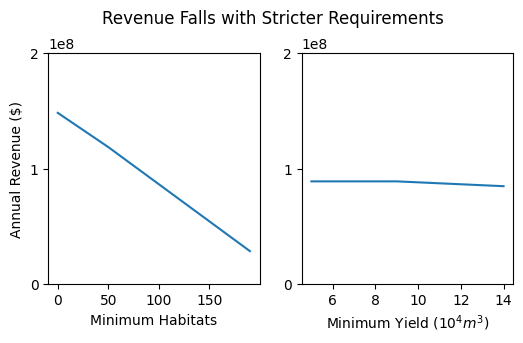

In [225]:
yield_min.values = 120000
pos_min_parrot = list(range(0, 200, 10))
parrot_profit = []
for val in pos_min_parrot:
    parrots_min.value = val
    sol = prob.solve()
    parrot_profit.append(sol)

parrots_min.value = 100
pos_min_yield = list(range(50000, 150000, 10000))
yield_profit = []
for val in pos_min_yield:
    yield_min.value = val
    sol = prob.solve()
    yield_profit.append(sol)

fig, ax = plt.subplots(1, 2, figsize=(6, 3))

ax[0].plot(pos_min_parrot, parrot_profit)
ax[0].set_xlabel('Minimum Habitats')
ax[0].set_ylabel('Annual Revenue ($)')
ax[0].set_yticks([0, 100000000, 200000000])

ax[1].plot(pos_min_yield, yield_profit)
ax[1].set_xlabel('Minimum Yield ($10^4 m^3$)')
ax[1].set_xticklabels([int(x/10000) for x in ax[1].get_xticks()])
ax[1].set_yticks([0, 100000000, 200000000])
ax[1].set_ybound(ax[0].get_ybound())

fig.suptitle('Revenue Falls with Stricter Requirements', y=1.025)

plt.show()

# Layout

In [226]:
mill_location = (80, 145)

## Roads

In [336]:
class RoadNetwork:
    def __init__(self, width=173, height=173):
        self.width = width
        self.height = height
        self.waypoints = {mill_location}
    
    def add_waypoint(self, x, y):
        self.waypoints.add((x, y))
    
    def delete_waypoint(self, x, y):
        self.waypoints.remove((x, y))
    
    def pave(self, origin, dest, roads):
        x, y = origin
        x_dir = 1 if dest[0] > origin[0] else -1
        y_dir = 1 if dest[1] > origin[1] else -1

        while x != dest[0] or y != dest[1]:
            if y_dir and roads[x, y + y_dir]:
                y += y_dir
                continue
            if x_dir and roads[x + x_dir, y]:
                x += x_dir
                continue

            y_dist = abs(dest[1] - y)
            x_dist = abs(dest[0] - x)
            if random.random() < y_dist/(x_dist + y_dist):
                y += y_dir
            else:
                x += x_dir
            roads[x, y] = 1
            
            if y == dest[1]:
                y_dir = 0
            if x == dest[0]:
                x_dir = 0
        
        return roads

    
    def layout(self):
        roads = np.zeros((self.height, self.width))
        roads[mill_location[0], mill_location[1]] = 1
        # self.pave(mill_location, (mill_location[0], self.height - 1), roads)
        for x, y in self.waypoints:
            if not roads[x, y]:
                print(f"navigating to {x}, {y}")
                roads = self.pave(mill_location, (x, y), roads)
        return roads



## Cost Function

In [ ]:
# cost of building roads

# value of harvesting existing forest

# number of parrot habitats

# expected annual revenue

True

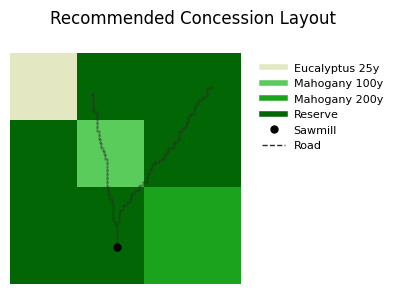

In [341]:
n = 173
layout = np.zeros((n, n))
layout[0:50, 0:50] = 1
layout[50:100, 50:100] = 2
layout[100:173, 100:173] = 3

def plot_map(layout, roads=None, title=None):
    fig, ax = plt.subplots(1, 2, width_ratios=(3, 1.4), figsize=(5, 3))

    cmap = ListedColormap(['#026604', '#e3e8c3', '#5acc5c', '#1ca31e'])
    lines = [
        # region colors
        
        Line2D([0], [0], color=cmap(1), lw=4),
        Line2D([0], [0], color=cmap(2), lw=4),
        Line2D([0], [0], color=cmap(3), lw=4),
        Line2D([0], [0], color=cmap(0), lw=4),
        Line2D([0], [0], color='black', marker='o', markersize=5, linestyle='None'),
        Line2D([0], [0], color="#302d2a", lw=1, linestyle="dashed"),
    ]
    ax[1].legend(lines, ["Eucalyptus 25y", "Mahogany 100y", "Mahogany 200y", "Reserve", "Sawmill", "Road"], fontsize=8, frameon=False)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].axis('off')

    ax[0].imshow(layout, cmap=cmap, interpolation='nearest')
    ax[0].plot(mill_location[0], mill_location[1], 'o', markersize=5, color='black', label='Sawmill')
    ax[0].axis('off')

    if roads is not None:
        ax[0].scatter(*np.where(roads), color='#302d2a', s=0.05)

    if title:
        fig.suptitle(title, y=1.025)
    return fig

plot_map(layout, roads=road_map, title="Recommended Concession Layout")
True